In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
import shutil
import pandas as pd
import pickle
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
# rcParams['figure.figsize']=10,10
import sys
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import cv2
%matplotlib inline

In [4]:
!wget 'https://fyp-content-bucket.s3.amazonaws.com/MICC-F2000.7z'

--2019-11-07 15:58:01--  https://fyp-content-bucket.s3.amazonaws.com/MICC-F2000.7z
Resolving fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)... 52.216.206.211
Connecting to fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)|52.216.206.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3014281120 (2.8G) [application/x-7z-compressed]
Saving to: ‘MICC-F2000.7z’

MICC-F2000.7z       100%[===================>]   2.81G  95.8MB/s    in 43s     

2019-11-07 15:58:44 (67.1 MB/s) - ‘MICC-F2000.7z’ saved [3014281120/3014281120]



In [5]:
!7z x MICC-F2000.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 3014281120 bytes (2875 MiB)

Extracting archive: MICC-F2000.7z
--
Path = MICC-F2000.7z
Type = 7z
Physical Size = 3014281120
Headers Size = 18469
Method = LZMA2:26
Solid = +
Blocks = 1

  0%      0% 3        0% 5 - MICC-F2000/Authentic/00001_scale.jpg                                               0% 7 - MICC-F2000/Authentic/00003_2_scale.jpg                                                 0% 8 - MICC-F2000/Authentic/00003_scale.jpg                                          

# Data Exploration and Augmentation

The unzip file contains a dataset of 2000 images of which some have been manipulated using a Copy-Move technique. Inside are two directories which have the images split into the following categories:

*   *Authentic*
*   *Tampered*

The *Authentic* directory contains 1300 untouched / real images.

The *Tampered* directory contains 700 fake / manipulated images. 



In [4]:
ROOT_PATH = 'MICC-F2000/'
PATH_TO_FAKES = ROOT_PATH + 'Tampered/'
PATH_TO_REALS = ROOT_PATH + 'Authentic/'
print('Number of Tampered = {}'.format(len(os.listdir(PATH_TO_FAKES))))
print('Number of Originals = {}'.format(len(os.listdir(PATH_TO_REALS))))

Number of Tampered = 700
Number of Originals = 1300


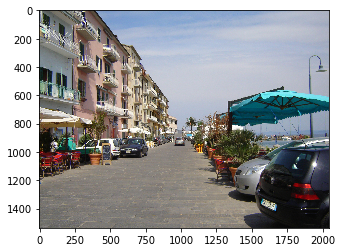

In [8]:
# Real Image Example
tamp_img = imread(PATH_TO_FAKES + 'DSC01640tamp10.jpg')
real_img = imread(PATH_TO_REALS + 'DSC01640_scale.jpg')
plt.imshow(real_img)

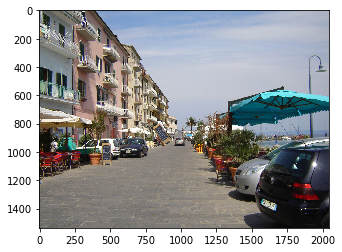

In [8]:
# Fake Image Example
plt.imshow(tamp_img)

## Problem Mapping

For a given image, predict whether an image is fake (has been manipulated) or is real (remains untouched). The images will be classified using binary classification where a 1 will signify the image is fake and 0 the image is real.

The groundtruthDB_2000.txt file found in the MICC-F2000 dataset, has each image labelled with a 1 or 0.

### Images Shapes
Checking the shape of a random sample of real and fake images

In [0]:
real_images = os.listdir(PATH_TO_REALS)[1:-1]
tamp_images = os.listdir(PATH_TO_FAKES)[1:-1]
real_images_shapes = []
tamp_images_shapes = []

In [0]:
for real in real_images:
    real_images_shapes.append(imread(PATH_TO_REALS + real).shape)

for tampered in tamp_images:
    tamp_images_shapes.append(imread(PATH_TO_FAKES + tampered).shape)

In [13]:
for i in range(50):
    real_index = np.random.randint(0, len(real_images_shapes))
    print(str(real_index) +'\t'+ str(real_images_shapes[real_index]) +'\t'+ real_images[real_index])

203	(1536, 2048, 3)	P1020784_scale.jpg
1131	(1536, 2048, 3)	IMG_2163_scale.jpg
914	(1536, 2048, 3)	00014_2_scale.jpg
647	(1536, 2048, 3)	DSC_0344_scale.jpg
391	(1536, 2048, 3)	DSC_0768_scale.jpg
1160	(1536, 2048, 3)	DSC_1345_scale.jpg
989	(1536, 2048, 3)	DSC_0106_scale.jpg
1154	(1536, 2048, 3)	DSC_1266_scale.jpg
324	(1536, 2048, 3)	P7020161_scale.jpg
1273	(1536, 2048, 3)	P1020701_scale.jpg
690	(1536, 2048, 3)	P1020810_scale.jpg
445	(1536, 2048, 3)	DSC_1140_scale.jpg
1027	(1536, 2048, 3)	DSC_1032_scale.jpg
368	(1536, 2048, 3)	DSC_0079_scale.jpg
635	(1536, 2048, 3)	DSC_0218_scale.jpg
1195	(1536, 2048, 3)	DSC_0083_01_scale.jpg
1009	(1536, 2048, 3)	IMG_2336_scale.jpg
1051	(1536, 2048, 3)	DSC_0128_01_scale.jpg
351	(1536, 2048, 3)	DSC_0179_scale.jpg
432	(1536, 2048, 3)	DSC01207_scale.jpg
1012	(1536, 2048, 3)	P1020762_scale.jpg
334	(1536, 2048, 3)	DSC_0427_scale.jpg
993	(1536, 2048, 3)	DSC_0154_scale.jpg
868	(1536, 2048, 3)	DSC_0282_scale.jpg
707	(1536, 2048, 3)	DSC01177_scale.jpg
351	(1536, 

In [14]:
for i in range(50):
    tamp_index = np.random.randint(0,len(tamp_images_shapes))
    print(str(tamp_index) +'\t'+ str(tamp_images_shapes[tamp_index]) +'\t'+ tamp_images[tamp_index])

406	(1536, 2048, 3)	P1000528tamp9.jpg
267	(1536, 2048, 3)	DSC_0264tamp5.jpg
573	(1536, 2048, 3)	DSC_0242_01tamp8.jpg
633	(1536, 2048, 3)	DSCN2329tamp8.jpg
674	(1536, 2048, 3)	DSCF1248tamp4.jpg
265	(1536, 2048, 3)	DSC_0409tamp13.jpg
85	(1536, 2048, 3)	DSC_1535tamp10.jpg
8	(1536, 2048, 3)	DSCF1853tamp11.jpg
39	(1536, 2048, 3)	DSC01640tamp12.jpg
226	(1536, 2048, 3)	PC190612tamp8.jpg
51	(1536, 2048, 3)	DSC_0215_01tamp5.jpg
163	(1536, 2048, 3)	DSC_0535tamp8.jpg
659	(1536, 2048, 3)	DSC_0055_01tamp13.jpg
537	(1536, 2048, 3)	DSCF0018tamp14.jpg
131	(1536, 2048, 3)	PA260237tamp3.jpg
687	(1536, 2048, 3)	DSCF1248tamp3.jpg
356	(1536, 2048, 3)	DSC_0535tamp6.jpg
671	(1536, 2048, 3)	DSCF1248tamp12.jpg
668	(1536, 2048, 3)	DSC_1568tamp13.jpg
31	(1536, 2048, 3)	DSCF1337tamp7.jpg
559	(1536, 2048, 3)	DSC_0409tamp1.jpg
582	(1536, 2048, 3)	DSC_0055_01tamp2.jpg
627	(2048, 1536, 3)	DSCN47tamp6.jpg
215	(1536, 2048, 3)	DSC_1811tamp5.jpg
31	(1536, 2048, 3)	DSCF1337tamp7.jpg
611	(1536, 2048, 3)	PA260237tamp9.jpg
3

From the above we can see that every image has got the same shape and number of channels, 3.

However, it appears that some images might be in different orientations to others.

Image 626 has a shape of (2048, 1536, 3) rather than what the rest have, (1536, 2048, 3), suggesting that that image could be in a portrait orientation.

In [8]:
# Create a list of all image names
real_images = os.listdir(PATH_TO_REALS)
tamp_images = os.listdir(PATH_TO_FAKES)
image_names = []
for i in range(0, len(real_images)):
    image_names.append(real_images[i])
for i in range(0, len(tamp_images)):
    image_names.append(tamp_images[i])

print(len(image_names))

2000


Data Augmentation & Train/Test Split


In [0]:
# labels[1] = tampered
# labels[0] = real
labels = [1]*700+[0]*1300

# Stratifying so we have approximately the same 
# percentage of samples for in the train/test set
x_train, x_test, y_train, y_test = train_test_split(image_names, 
                                                    labels, 
                                                    test_size=0.33, 
                                                    stratify=labels)


x_train_images = []
for i in x_train:
    if(i.__contains__('tamp')):
        img = imread(PATH_TO_FAKES + i)
        x_train_images.append(img)
    else:
        img = imread(PATH_TO_REALS + i)
        x_train_images.append(img)


Tried using a try/except above but it was consumming too much RAM

In [25]:
print(len(x_train))
print(x_test[110])

1340
IMG_2178_scale.jpg


In [0]:
x_train_fake_names=[]
x_train_fake_images=[]

for i, x in enumerate(x_train):
    if y_train[i]==0:
        x_train_fake_names.append(x)
        x_train_fake_images.append(x_train_images[i])

In [0]:
x_train_real_names=[]
x_train_real_images=[]

for i, x in enumerate(x_train):
    if y_train[i]==1:
        x_train_real_names.append(x)
        x_train_real_images.append(x_train_images[i])

In [0]:
labels